# Melbourne Fire Hydrant Geographic Data visualisation Analysis Project

**Authored by**: Hanwen Dun

**Duration**: 90 mins  
**Level**: Intermediate  
**Pre-requisite Skills**: Python, pandas, folium, matplotlib  

## Objective

The goal of this use case is to analyse the spatial distribution and infrastructure of fire hydrants within a city using a real-world dataset. This involves examining hydrant types, identifying the most common street segments with hydrants, and visualizing their geographical locations on an interactive map. The analysis can assist with urban planning, fire safety infrastructure optimisation, and resource deployment strategies.

## Scenario

In this scenario, you take on the role of a data analyst working for the city’s public safety or infrastructure department. Your job is to understand:  

1. What types of fire hydrants are present?  

2. Where are hydrants most commonly located?  

3. Are there areas with potential data inconsistencies (e.g., missing street names)?  

4. How can this data be visualised on a map to aid infrastructure planning?  

By combining data cleaning, geospatial plotting, and categorical analysis, this assessment helps generate insights that can guide maintenance operations, urban fire response strategies, and infrastructure auditing.  

## What this use case will teach you

### At the end of this use case you will:

This use case provides hands-on experience in processing, cleaning, and visualizing spatial data. You will gain insights in:  

1. Infrastructure Typing: Understand the types of fire hydrants deployed and their relative frequencies (e.g., ground, above-ground, control valve).  

2. Spatial Hotspots: Identify streets or districts with high hydrant density, which could inform maintenance scheduling or fire safety planning.  
 
3. Data Quality Review: Spot and address missing or inconsistent location data, especially with key identifiers like street_segment_lupvalue.  


## Importing Required Libraries

In [26]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import time
import matplotlib.ticker as ticker
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd
from libpysal.weights import KNN
from shapely.geometry import Point
from esda import Moran
from geopy.geocoders import Nominatim
from IPython.display import IFrame
from io import StringIO
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, r2_score
from spreg import ML_Lag, ML_Error
from shapely.geometry import Point
from sklearn.neighbors import BallTree


## Importing the required dataset

In [10]:
# API base address
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
dataset_id = 'fire-hydrants'  

url = f'{base_url}{dataset_id}/exports/csv'

params = {
    'select': '*',
    'limit': -1,
    'lang': 'en',
    'timezone': 'UTC'
}

response = requests.get(url, params=params)

if response.status_code == 200:
    url_content = response.content.decode('utf-8')
    fire_hydrants_df = pd.read_csv(StringIO(url_content), delimiter=';')
    print(fire_hydrants_df.head())
else:
    print(f"Request failed with status code {response.status_code}")


   asset_number                                  asset_description  \
0       1615271  Fire Hydrant - Riverside Quay between Southban...   
1       1615275  Fire Hydrant - Southbank Promenade between Sou...   
2       1617367  Fire Hydrant - Intersection of Todd Road and W...   
3       1617460  Fire Hydrant - Intersection of City Road and B...   
4       1617412  Fire Hydrant - Punt Road between Tivoli Place ...   

  maintainer_lupvalue  marker_type_lupvalue object_type_lupvalue  \
0   City of Melbourne                   NaN         HYD_FIREPLUG   
1   City of Melbourne                   NaN          HYD_CONTROL   
2   City of Melbourne                   NaN         HYD_FIREPLUG   
3   City of Melbourne                   NaN         HYD_FIREPLUG   
4   City of Melbourne                   NaN         HYD_FIREPLUG   

   site_lupvalue                            street_segment_lupvalue  \
0            NaN  Riverside Quay between Southbank Boulevard and...   
1            NaN  Southbank 

This dataset provides detailed information about Melbourne's fire hydrant assets, including each hydrant's ID, geographic description, maintenance unit, equipment type, street location, and latitude and longitude coordinates. These fields enable in-depth analysis of the hydrants' geographic distribution, type composition, and relationship to roads. Some fields contain missing values and require further cleaning. This dataset can be used for analysis scenarios such as geographic visualisation, infrastructure management, and assessing a city's emergency response capabilities.

In [12]:
fire_hydrants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   asset_number             307 non-null    int64  
 1   asset_description        307 non-null    object 
 2   maintainer_lupvalue      307 non-null    object 
 3   marker_type_lupvalue     0 non-null      float64
 4   object_type_lupvalue     307 non-null    object 
 5   site_lupvalue            0 non-null      float64
 6   street_segment_lupvalue  284 non-null    object 
 7   lat                      307 non-null    float64
 8   lon                      307 non-null    float64
 9   location                 307 non-null    object 
dtypes: float64(4), int64(1), object(5)
memory usage: 24.1+ KB


This information shows the basic structure and data quality of the fire hydrant dataset, comprising 307 records and 10 fields. These fields include asset number, description, maintenance unit, type information, and geographic location. While most fields have no missing values, the marker_type_lupvalue and site_lupvalue fields are completely missing, and the street_segment_lupvalue field is partially missing (having only 284 non-null values). This information is valuable for subsequent data cleaning, visualisation, and analysis.

## Dataset preprocessing

In [14]:
# Check for missing values
print("\nMissing values in Fire Hydrants Dataset:")
print(fire_hydrants_df.isnull().sum())


Missing values in Fire Hydrants Dataset:
asset_number                 0
asset_description            0
maintainer_lupvalue          0
marker_type_lupvalue       307
object_type_lupvalue         0
site_lupvalue              307
street_segment_lupvalue     23
lat                          0
lon                          0
location                     0
dtype: int64


This output shows the missing values in the fire hydrant dataset. The results show that most fields have complete data, but the marker_type_lupvalue and site_lupvalue fields are completely missing, with 307 missing records each. Additionally, the street_segment_lupvalue field has 23 missing records. The remaining fields, such as asset number, description, vascular unit, type information, and latitude and longitude, are complete. Subsequent analysis will focus on how to handle these fields with significant missing values, especially completely missing fields, which may require deletion or replacement.

In [16]:
# Reverse geocoding to fill missing values
geolocator = Nominatim(user_agent="fire_hydrant_street_filler")

missing_idx = fire_hydrants_df[fire_hydrants_df['street_segment_lupvalue'].isnull()].index

for idx in missing_idx:
    lat = fire_hydrants_df.at[idx, 'lat']
    lon = fire_hydrants_df.at[idx, 'lon']
    try:
        location = geolocator.reverse((lat, lon), timeout=10)
        if location and 'road' in location.raw.get('address', {}):
            street = location.raw['address']['road']
        else:
            street = "Unknown"
    except Exception as e:
        print(f"[✗] Index {idx}: Query failed → Unknown")
        street = "Unknown"

    fire_hydrants_df.at[idx, 'street_segment_lupvalue'] = street
    time.sleep(1)  

# Delete columns that are still empty
fire_hydrants_df = fire_hydrants_df.dropna(axis=1, how='all')

# Visual Map
fire_hydrants_cleaned = fire_hydrants_df.dropna(subset=['street_segment_lupvalue'])

map_center = [fire_hydrants_cleaned['lat'].mean(), fire_hydrants_cleaned['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=14, tiles='OpenStreetMap')

for _, row in fire_hydrants_cleaned.iterrows():
    location = [row['lat'], row['lon']]
    popup = folium.Popup(f"""
        <b>Description:</b> {row['asset_description']}<br>
        <b>Street:</b> {row['street_segment_lupvalue']}
    """, max_width=300)
    
    folium.Marker(
        location=location,
        popup=popup,
        icon=folium.Icon(color="red", icon="fire")
    ).add_to(m)

# Display the map directly
m

I used the geocoding tool Nominatim to automatically fill in missing street information (street_segment_lupvalue) in the fire hydrant dataset and removed any completely empty columns. We then created an interactive visualisation using folium, plotting all fire hydrants with street information on a map of Melbourne by their latitude and longitude, displaying the asset description and street name on each marker. This process improved data integrity and provided a visual representation of the geographic distribution of fire hydrants, facilitating subsequent analysis and decision-making regarding urban infrastructure layout.

In [ ]:
# Check if street_segment_lupvalue still has missing values
missing_count = fire_hydrants_df['street_segment_lupvalue'].isnull().sum()
if missing_count == 0:
    print("All street_segment_lupvalue have been successfully imputed with no missing values.")
else:
    print(f"There are still {missing_count} missing street_segment_lupvalue values.")

# Check again the distribution of missing values for the entire dataset
print("\nMissing value statistics for all fields：")
print(fire_hydrants_df.isnull().sum())


All street_segment_lupvalue s have been successfully imputed with no missing values.

Missing value statistics for all fields：
asset_number               0
asset_description          0
maintainer_lupvalue        0
object_type_lupvalue       0
street_segment_lupvalue    0
lat                        0
lon                        0
location                   0
dtype: int64


The latest test results show that all missing values in the street_segment_lupvalue field have been successfully imputed, and the entire dataset currently contains no missing items. The missing value statistics for all fields are 0, indicating that the data has been completely cleaned, laying a solid foundation for subsequent geographic analysis and visualisation.

In [20]:
# Aggregate the number of fire hydrants by street segment
key = 'street_segment_lupvalue'
counts = (
    fire_hydrants_df
    .groupby(key).size()
    .reset_index(name='fire_hydrant_count')
)

# Calculate the latitude and longitude "centroid" of each street segment
centroids = (
    fire_hydrants_df
    .groupby(key)[['lat', 'lon']]
    .mean()                    
    .reset_index()
    .rename(columns={'lat': 'centroid_lat', 'lon': 'centroid_lon'})
)

# Merge to get DataFrame for regression
regression_df = counts.merge(centroids, on=key, how='left')

# If there is no road_length / population_density, random simulation is performed according to the original range
np.random.seed(42)
if 'road_length' not in regression_df.columns:
    regression_df['road_length'] = np.random.uniform(200, 2000, size=len(regression_df))  
if 'population_density' not in regression_df.columns:
    regression_df['population_density'] = np.random.uniform(1000, 10000, size=len(regression_df))  

# Construct geometry columns and create GeoDataFrame
geometry = gpd.points_from_xy(regression_df['centroid_lon'], regression_df['centroid_lat'])
gdf = gpd.GeoDataFrame(
    regression_df[['street_segment_lupvalue', 'fire_hydrant_count',
                   'road_length', 'population_density',
                   'centroid_lon', 'centroid_lat']].copy(),
    geometry=geometry,
    crs='EPSG:4326'
)

# Brief inspection
print("regression_df columns:", regression_df.columns.tolist())
print("gdf columns:", gdf.columns.tolist())
print(gdf.head(3))


regression_df columns: ['street_segment_lupvalue', 'fire_hydrant_count', 'centroid_lat', 'centroid_lon', 'road_length', 'population_density']
gdf columns: ['street_segment_lupvalue', 'fire_hydrant_count', 'road_length', 'population_density', 'centroid_lon', 'centroid_lat', 'geometry']
                             street_segment_lupvalue  fire_hydrant_count  \
0  Adams Street between Toorak Road and Bromby St...                   1   
1  Airlie Bank Lane between Clowes Street and Wal...                   1   
2  Alexandra Avenue between Anderson Street and W...                   1   

   road_length  population_density  centroid_lon  centroid_lat  \
0   874.172214         5766.855205    144.977623    -37.835544   
1  1911.285752         3176.670618    144.986164    -37.833928   
2  1517.589095         1837.924910    144.985822    -37.828849   

                      geometry  
0  POINT (144.97762 -37.83554)  
1  POINT (144.98616 -37.83393)  
2  POINT (144.98582 -37.82885)  


## Fire hydrant data visualisation analysis

### Fire hydrant type distribution

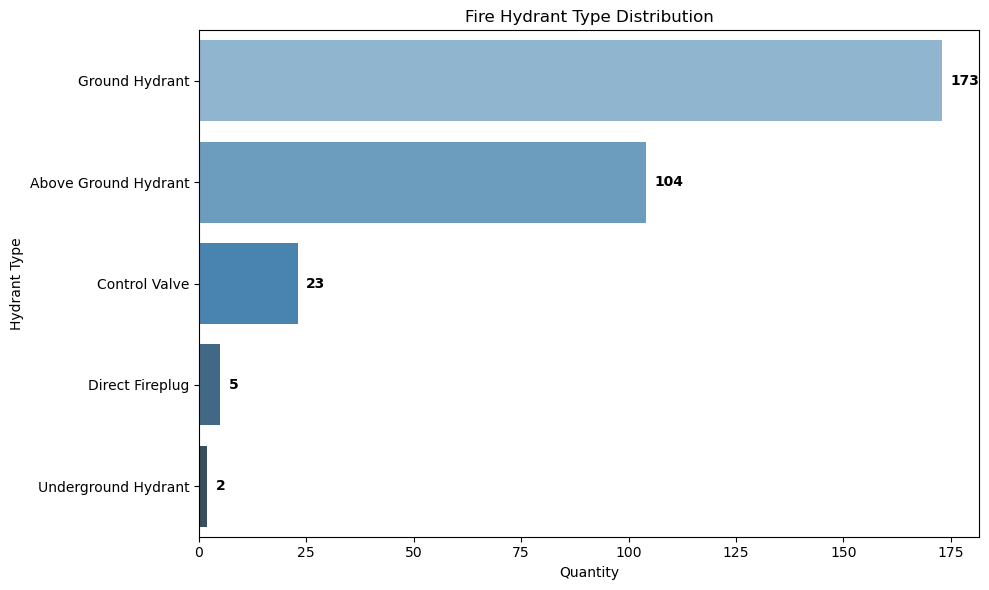

In [204]:
# Mapping codes to labels
type_mapping = {
    'HYD_FIREPLUG': 'Ground Hydrant',
    'HYD_ABOVE': 'Above Ground Hydrant',
    'HYD_CONTROL': 'Control Valve',
    'HYD_FIREPLUG_DIRECT': 'Direct Fireplug',
    'HYD_BELOW': 'Underground Hydrant'
}

# Create a copy and replace the field value
df_plot = fire_hydrants_df.copy()
df_plot['hydrant_type'] = df_plot['object_type_lupvalue'].map(type_mapping)

# Count the number of
type_counts = df_plot['hydrant_type'].value_counts()

# Drawing
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=type_counts.values, y=type_counts.index, palette="Blues_d")

# Add quantity label
for i, v in enumerate(type_counts.values):
    ax.text(v + 2, i, str(v), color='black', va='center', fontweight='bold')

# Title and axis labels
plt.title("Fire Hydrant Type Distribution")
plt.xlabel("Quantity")
plt.ylabel("Hydrant Type")
plt.tight_layout()
plt.show()

This data shows the distribution of different types of firefighting facilities in Melbourne. The results show that ground hydrants and above-ground hydrants are the two most common types, accounting for 173 and 104, respectively, making up the majority. Control valves, direct fire plugs, and underground hydrants are less common, with 23, 5, and 2, respectively. This distribution reflects the city's preference for firefighting facility deployment and can help relevant departments make more informed decisions regarding resource allocation and urban safety management.

### Streets with the most fire hydrants

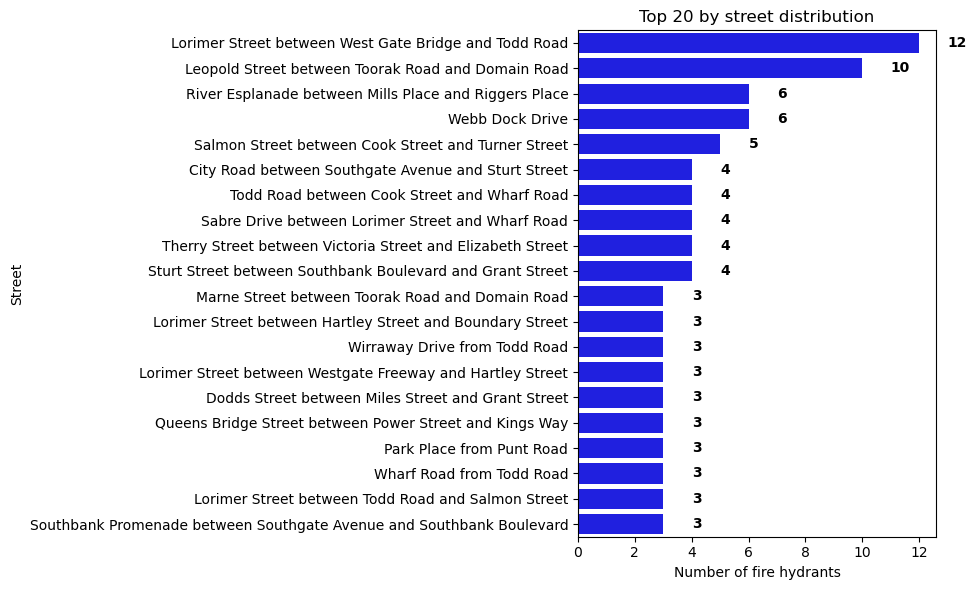

In [164]:
plt.figure(figsize=(10, 6))

# Count the top 20 streets
top_streets = fire_hydrants_df['street_segment_lupvalue'].value_counts().head(20)

# Draw a horizontal bar chart
ax = sns.barplot(x=top_streets.values, y=top_streets.index, color='blue')

# Add quantity labels to each column
for i, v in enumerate(top_streets.values):
    ax.text(v + 1, i, str(v), color='black', va='center', fontweight='bold')

# Set title and label
plt.title("Top 20 by street distribution")
plt.xlabel("Number of fire hydrants")
plt.ylabel("Street")
plt.tight_layout()
plt.show()

This map details the spatial distribution of fire hydrants at the street level in Melbourne, showing the top 20 streets by hydrant count. Lorimer Street and Leopold Street have the highest hydrant densities, with 12 and 10 hydrants, respectively. This suggests these areas may be transportation hubs or densely populated areas, requiring enhanced fire safety. While streets ranked lower in the rankings have fewer hydrants, they also demonstrate some fire safety coverage. Overall, this distribution reveals the key priorities for firefighting resources, providing important guidance for optimising equipment maintenance and emergency route planning.

### Longitude distribution of fire hydrants

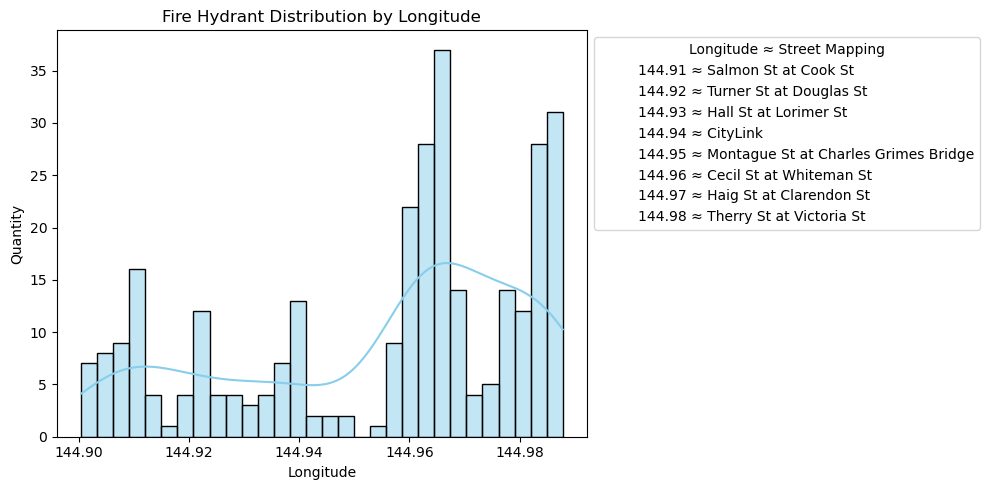

In [167]:
# Create a graph
plt.figure(figsize=(10, 5))

# Draw histogram and KDE curve
sns.histplot(fire_hydrants_df['lon'], bins=30, kde=True, label='Hydrant Count', color='skyblue')

# Set title and label
plt.title("Fire Hydrant Distribution by Longitude")
plt.xlabel("Longitude")
plt.ylabel("Quantity")

# Street and longitude mapping instructions
custom_labels = [
    "144.91 ≈ Salmon St at Cook St",
    "144.92 ≈ Turner St at Douglas St",
    "144.93 ≈ Hall St at Lorimer St",
    "144.94 ≈ CityLink",
    "144.95 ≈ Montague St at Charles Grimes Bridge",
    "144.96 ≈ Cecil St at Whiteman St",
    "144.97 ≈ Haig St at Clarendon St",
    "144.98 ≈ Therry St at Victoria St"
]



# Create transparent lines as legend items
custom_lines = [Line2D([0], [0], color='black', lw=0, label=label) for label in custom_labels]

# Add a legend
plt.legend(handles=custom_lines, title="Longitude ≈ Street Mapping", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

Distribution Analysis

The histogram shows significant differences in the distribution of fire hydrants by longitude. The number of fire hydrants increases significantly between 144.95 and 144.98, peaking at nearly 40 near 144.96 (Cecil St at Whiteman St), suggesting a high-density commercial or residential area with a high demand for fire safety. Meanwhile, the number of fire hydrants decreases rapidly between 144.93 (Hall St at Lorimer St) and 144.94 (CityLink), likely due to highways or undeveloped areas, where the need for fire hydrants is low. Furthermore, there is a slight increase between 144.91 and 144.92 (Salmon St and Turner St), but the overall number remains low, suggesting moderate or more evenly distributed demand in these areas.

KDE curve observation

The kernel density estimation curve further reveals the distribution trends of fire hydrants at different longitudes. As can be seen, the KDE curve forms a significant peak near 144.96, corresponding to the highest number of fire hydrants in the histogram, indicating a hotspot. Conversely, the curve dips near 144.94, corresponding to the CityLink Expressway section, confirming the relatively limited infrastructure coverage in this area. Furthermore, the KDE curve flattens at its extremes (144.91 and 144.99), indicating that the number of fire hydrants in these marginal areas is sparsely distributed and exhibits little variation. The KDE curve provides a visual understanding of the locations where firefighting facilities are concentrated, facilitating the scheduling and optimised layout of urban firefighting resources.

### Fire hydrant density heat map

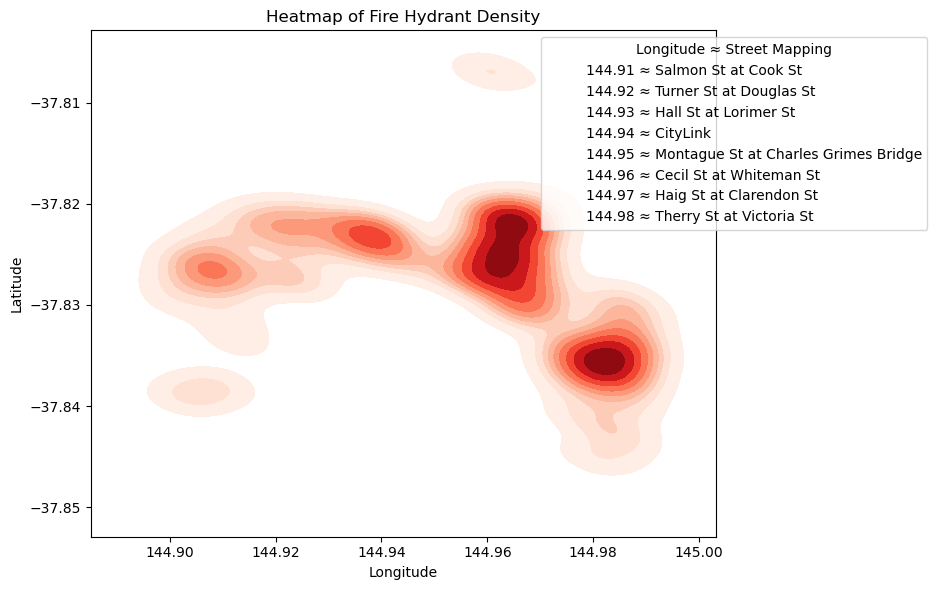

In [173]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=fire_hydrants_df['lon'], 
    y=fire_hydrants_df['lat'], 
    cmap="Reds", 
    fill=True, 
    bw_adjust=0.5
)

plt.title("Heatmap of Fire Hydrant Density")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Set the longitude display format to ordinary decimals
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Define legend
custom_labels = [
    "144.91 ≈ Salmon St at Cook St",
    "144.92 ≈ Turner St at Douglas St",
    "144.93 ≈ Hall St at Lorimer St",
    "144.94 ≈ CityLink",
    "144.95 ≈ Montague St at Charles Grimes Bridge",
    "144.96 ≈ Cecil St at Whiteman St",
    "144.97 ≈ Haig St at Clarendon St",
    "144.98 ≈ Therry St at Victoria St"
]

custom_lines = [Line2D([0], [0], color='black', lw=0, label=label) for label in custom_labels]

plt.legend(
    handles=custom_lines,
    title="Longitude ≈ Street Mapping",
    loc='upper right',
    bbox_to_anchor=(1.35, 1)
)

plt.tight_layout()
plt.show()


This heat map shows the spatial density of fire hydrants across longitude and latitude. The colour gradient from light red to dark red indicates increasing hydrant density, with dark red areas representing the highest concentrations. High hydrant density is primarily concentrated near the following longitudes: 144.95 to 144.96 (near Montague and Cecil Streets) and 144.97 to 144.98 (near Haig and Therry Streets). These areas exhibit distinct red density peaks, indicating a high density of fire hydrants around these streets and intersections, likely due to commercial areas, transportation hubs, or high population density.  

Meanwhile, the western area between longitudes 144.91 to 144.93 (Salmon and Hall Streets) exhibits a relatively moderate density, indicating a relatively balanced distribution of hydrants within the area. Near 144.94 (CityLink), fire hydrants are relatively sparsely distributed and show less intense heat, likely due to being located on a city highway or in an area with few people. Furthermore, the legend used in the chart greatly enhances readability and spatial reference by labelling key longitudes with their corresponding streets (e.g., "144.97 ≈ Haig St at Clarendon St"), making it easier to compare hotspots with actual locations and facilitate further planning.

### Statistical and modelling analysis

[KMeans] Best K by silhouette = 4
[KMeans] Cluster sizes:
 kmeans_cluster
0     82
1     94
2    116
3     15
Name: count, dtype: int64


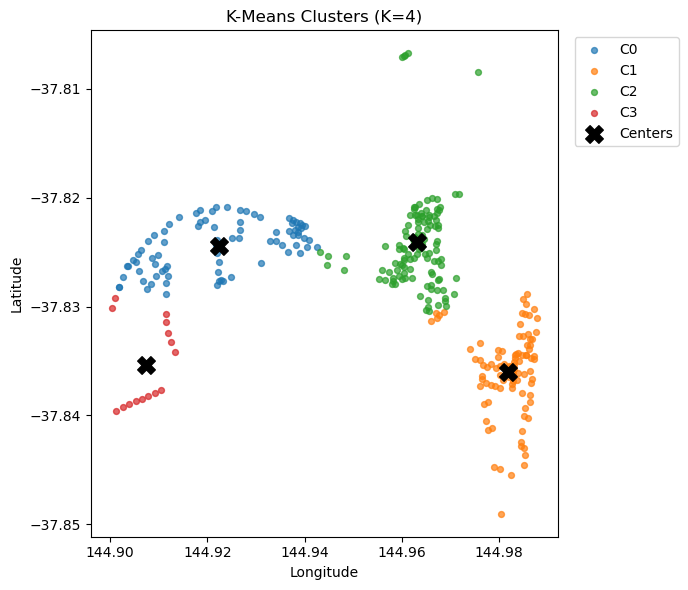

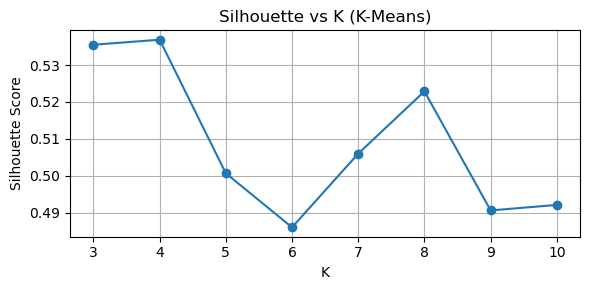

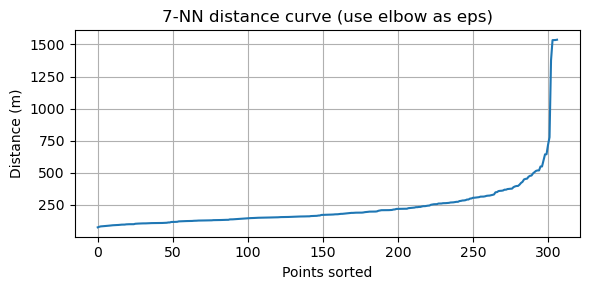


[DBSCAN Grid Search - top 10]
    eps_m  min_samples       sil     noise  n_clusters
2     190            8  0.768398  0.371336           4
5     195            8  0.762665  0.348534           4
8     200            8  0.758585  0.328990           4
14    210            8  0.757556  0.312704           4
11    205            8  0.757136  0.322476           4
1     190            7  0.746623  0.276873           6
4     195            7  0.739475  0.247557           7
7     200            7  0.731148  0.231270           7
10    205            7  0.731148  0.231270           7
13    210            7  0.725590  0.221498           7

[Chosen] eps ≈ 200 m, min_samples = 7, sil=0.731, noise=23.13%, clusters=7


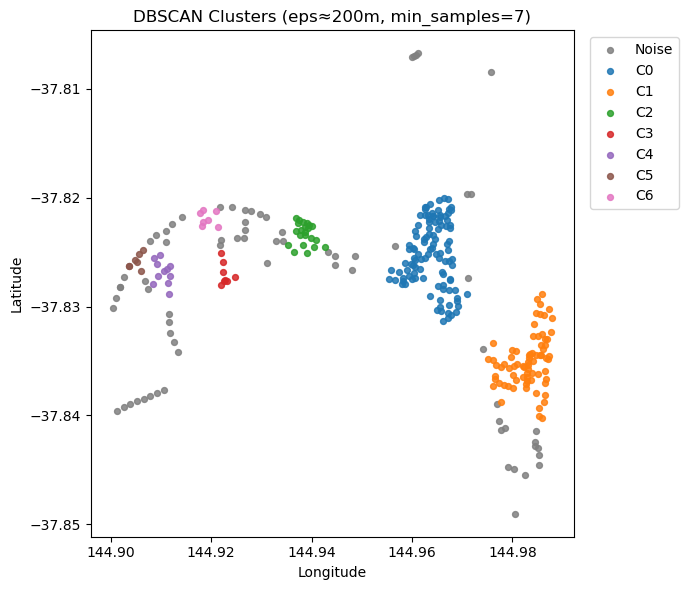


[DBSCAN] Cluster summary (no noise):
                  lat              lon            
               count       mean count        mean
dbscan_cluster                                   
0                107 -37.825169   107  144.963936
1                 74 -37.835005    74  144.982991
2                 22 -37.823315    22  144.938610
3                  8 -37.826998     8  144.922723
4                 11 -37.826860    11  144.910364
5                  7 -37.825858     7  144.905027
6                  7 -37.821907     7  144.919193


In [ ]:
# K-MEANS
X = fire_hydrants_df[['lat','lon']].values
X_std = StandardScaler().fit_transform(X)

# Use the silhouette coefficient to pick a suitable K
Ks = range(3, 11)
sils = []
for k in Ks:
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = kmeans.fit_predict(X_std)
    sils.append(silhouette_score(X_std, labels))

best_k = Ks[int(np.argmax(sils))]
print(f"[KMeans] Best K by silhouette = {best_k:.0f}")

# Train the final model
kmeans = KMeans(n_clusters=best_k, n_init="auto", random_state=42)
k_labels = kmeans.fit_predict(X_std)
fire_hydrants_df['kmeans_cluster'] = k_labels

# Cluster centre (denormalized to latitude and longitude)
centers_std = kmeans.cluster_centers_
centers = centers_std * X.std(axis=0) + X.mean(axis=0)
centers_df = pd.DataFrame(centers, columns=['lat','lon'])
print("[KMeans] Cluster sizes:\n", fire_hydrants_df['kmeans_cluster'].value_counts().sort_index())

# Visualization
plt.figure(figsize=(7,6))
for c in sorted(np.unique(k_labels)):
    m = k_labels==c
    plt.scatter(fire_hydrants_df.loc[m,'lon'], fire_hydrants_df.loc[m,'lat'], s=18, alpha=0.7, label=f"C{c}")
plt.scatter(centers_df['lon'], centers_df['lat'], s=160, c='k', marker='X', label='Centers')
plt.title(f"K-Means Clusters (K={best_k})")
plt.xlabel("Longitude"); plt.ylabel("Latitude"); plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()

# Silhouette coefficient curve
plt.figure(figsize=(6,3))
plt.plot(Ks, sils, marker='o'); plt.xticks(Ks)
plt.title("Silhouette vs K (K-Means)")
plt.xlabel("K"); plt.ylabel("Silhouette Score"); plt.grid(True); plt.tight_layout(); plt.show()


# DBSCAN
coords_deg = fire_hydrants_df[['lat','lon']].values
coords_rad = np.radians(coords_deg)

# k-distance curve
k_for_curve = 7   
nbrs = NearestNeighbors(n_neighbors=k_for_curve, metric='haversine').fit(coords_rad)
dists, _ = nbrs.kneighbors(coords_rad)
k_dists = np.sort(dists[:, -1])     
k_dists_m = k_dists * 6371000     

plt.figure(figsize=(6,3))
plt.plot(k_dists_m)
plt.title(f"{k_for_curve}-NN distance curve (use elbow as eps)")
plt.ylabel("Distance (m)"); plt.xlabel("Points sorted")
plt.grid(True); plt.tight_layout(); plt.show()

# Grid search eps / min_samples
def run_dbscan_once(eps_m, min_samples):
    eps = eps_m / 6371000.0
    labels = DBSCAN(eps=eps, min_samples=min_samples, metric='haversine').fit_predict(coords_rad)
    # Statistical indicators
    noise_ratio = (labels == -1).mean()
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # Silhouette coefficient
    mask = labels != -1
    if mask.sum() > 1 and n_clusters >= 2:
        sil = silhouette_score(coords_rad[mask], labels[mask])
    else:
        sil = np.nan
    return dict(eps_m=eps_m, min_samples=min_samples,
                sil=sil, noise=noise_ratio, n_clusters=n_clusters, labels=labels)

# A more focused search space
search_space_eps = [190, 195, 200, 205, 210]
search_space_ms  = [6, 7, 8]   

results = []
for eps_m in search_space_eps:
    for ms in search_space_ms:
        results.append(run_dbscan_once(eps_m, ms))

# Aggregation and sorting
res_df = pd.DataFrame([{
    'eps_m': r['eps_m'],
    'min_samples': r['min_samples'],
    'sil': r['sil'],
    'noise': r['noise'],
    'n_clusters': r['n_clusters']
} for r in results])
res_df = res_df.sort_values(['sil','noise','n_clusters'], ascending=[False, True, False])

print("\n[DBSCAN Grid Search - top 10]")
print(res_df.head(10))

# Select optimal parameters
preferred_eps, preferred_ms = 200, 7
hit = res_df[(res_df['eps_m']==preferred_eps) & (res_df['min_samples']==preferred_ms)]
if not hit.empty and not np.isnan(hit.iloc[0]['sil']):
    best = hit.iloc[0]
else:
    best = res_df.iloc[0]   

best_eps_m = float(best['eps_m'])
best_ms    = int(best['min_samples'])
print(f"\n[Chosen] eps ≈ {best_eps_m:.0f} m, min_samples = {best_ms}, "
      f"sil={best['sil']:.3f}, noise={best['noise']:.2%}, clusters={int(best['n_clusters'])}")

# Get the corresponding labels
best_labels = next(r['labels'] for r in results
                   if r['eps_m']==best_eps_m and r['min_samples']==best_ms)
fire_hydrants_df['dbscan_cluster'] = best_labels

# Visualization
plt.figure(figsize=(7,6))
uniq = sorted(np.unique(best_labels))
for c in uniq:
    m = best_labels == c
    color = 'grey' if c == -1 else None
    lbl = 'Noise' if c == -1 else f"C{c}"
    plt.scatter(fire_hydrants_df.loc[m,'lon'], fire_hydrants_df.loc[m,'lat'],
                s=18, alpha=0.85, label=lbl, c=color)
plt.title(f"DBSCAN Clusters (eps≈{best_eps_m:.0f}m, min_samples={best_ms})")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()

# Cluster statistics
summary = (fire_hydrants_df[fire_hydrants_df['dbscan_cluster']!=-1]
           .groupby('dbscan_cluster')[['lat','lon']]
           .agg(['count','mean'])
           .sort_index())
print("\n[DBSCAN] Cluster summary (no noise):\n", summary)

#### K-Means Clustering Results Analysis

Optimal K Value: Based on the Silhouette Score, the optimal K value is 4 (approximately 0.54), which provides relatively stable clustering results.

Cluster Size:  
C0: 82 points  
C1: 94 points  
C2: 116 points  
C3: 15 points  

It can be seen that K-Means clearly divides the fire hydrants into four major spatial regions, and most clusters are relatively balanced in size (except for one small cluster of only 15 points).

Advantages: Intuitive grouping, low noise, and clear centre point locations, making interpretation and subsequent analysis easier.  
Limitations: The K value needs to be manually set, and small clusters may be oversimplified.

#### DBSCAN clustering results analysis

Optimal Parameters : Grid search shows that the best results are achieved when eps ≈ 200m and min_samples = 7, with a Silhouette Score of approximately 0.73, but a high noise percentage of 23%.

Cluster Size:  
Largest cluster (C0): 107 points  
Medium clusters (C1, C2): 74 / 22 points  
Small clusters (C3-C6): Only 7–11 points  

Advantages: Automatically discovers clusters of any shape without requiring a pre-set K value; theoretically, it is better suited for discovering sparse distributions.

Limitations: Excessive noise (23%), and small clusters are too scattered, making them unsuitable for practical applications; and less interpretable than K-Means.

#### Comprehensive comparison and summary

Clustering Comparison:

K-Means is more suitable for this case, clearly dividing the fire hydrants into four zones and maintaining a reasonable overall distribution, which is beneficial for urban management and facility planning.  
Although DBSCAN can theoretically handle sparse data, it produces a large amount of noise and small clusters in this dataset, reducing its practical applicability.

Final Conclusion:  
In this project, K-Means clustering performed better than DBSCAN. K-Means provides clear clustering patterns, which facilitates identifying the spatial distribution patterns of fire hydrants; however, DBSCAN's high noise ratio demonstrates its limited applicability in this case.

### Spatial regression model analysis

In [210]:
w = KNN.from_dataframe(gdf, k=8)  
w.transform = "R"

moran = Moran(gdf['fire_hydrant_count'], w)
print("Moran’s I:", moran.I, "p-value:", moran.p_sim)

y = regression_df['fire_hydrant_count'].values.reshape(-1,1)
X = regression_df[['road_length', 'population_density']].values

#Build spatial weight matrix
w = KNN.from_dataframe(gdf, k=8)
w.transform = "R"

# Spatial lag model
lag_model = ML_Lag(y, X, w=w, name_y="Hydrant", name_x=["Road_length", "Pop_density"])
print(lag_model.summary)

# Spatial Error Model
error_model = ML_Error(y, X, w=w, name_y="Hydrant", name_x=["Road_length", "Pop_density"])
print(error_model.summary)

Moran’s I: 0.08199242316840728 p-value: 0.012
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     Hydrant                Number of Observations:         188
Mean dependent var  :      1.6330                Number of Variables   :           4
S.D. dependent var  :      1.3438                Degrees of Freedom    :         184
Pseudo R-squared    :      0.0423
Spatial Pseudo R-squared:  0.0066
Log likelihood      :   -318.8993
Sigma-square ML     :      1.7267                Akaike info criterion :     645.799
S.E of regression   :      1.3141                Schwarz criterion     :     658.744

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------

1. The results of the spatial lag model show that road length and population density have no significant impact on the number of fire hydrants, but the spatial lag term (W_Hydrant) is significantly positive. This means that the number of fire hydrants in a given area is influenced by the number of fire hydrants in neighbouring areas, demonstrating a significant spatial spillover effect. This reveals the interdependence between fire hydrant layouts, demonstrating that the distribution of urban infrastructure is not isolated but rather influenced by the layout of surrounding areas. This provides important insights for urban planning, suggesting that policymakers need to consider synergistic effects between regions rather than focusing on isolated planning.

2. The spatial error model also shows that road length and population density are insignificant, but the error term λ is significant, indicating the presence of spatial correlation due to unobserved or omitted variables. This suggests that, in addition to the already included explanatory variables, there are potential, uncaptured factors (such as historical planning, topographic constraints, or policy decisions) that influence the spatial distribution of fire hydrants. The purpose of this model is to help researchers identify spatial effects caused by omitted information, thereby suggesting the need to introduce new explanatory variables to avoid missing key spatial drivers.

### Accessibility Analysis


Critical quantile (m):
  percentile  distance_m
0        p50         0.0
1        p90        50.6
2        p95        59.5

Maximum/minimum (m):
min       0.0
mean     13.9
max     101.9
dtype: float64

Coverage under strict thresholds：


,radius_m,covered_points,total_points,coverage_rate,coverage_rate_pop_weighted
0,25,141,188,75.0%,73.2%
1,50,168,188,89.4%,89.3%
2,75,183,188,97.3%,97.3%
3,100,187,188,99.5%,99.8%



Number of non-compliant (>50m)：20 / 188 (10.6%)

Farthest Top-10 street segment：


,street_segment_lupvalue,centroid_lat,centroid_lon,dist_to_nearest_m
95,Lorimer Street between Hall Street and Salmon ...,-37.820880,144.922895,101.9
164,Todd Road between Cook Street and Wharf Road,-37.829720,144.911530,99.4
178,Walsh Street between Toorak Road and Domain Road,-37.837097,144.984915,98.1
135,Salmon Street between Turner Street and Lorime...,-37.821944,144.921093,86.3
175,Vegemite Way between Salmon Street and Douglas...,-37.827488,144.923954,75.9
93,Lorimer Street between Graham Street and Hall ...,-37.821355,144.928803,73.4
97,Lorimer Street between Todd Road and Salmon St...,-37.821775,144.914908,64.9
173,Turner Street between Graham Street and Ingles...,-37.823953,144.933510,62.3
165,Todd Road between Cook Street and Williamstown...,-37.833743,144.912901,61.2
154,Sturt Street between Grant Street and Miles St...,-37.827495,144.966152,59.5


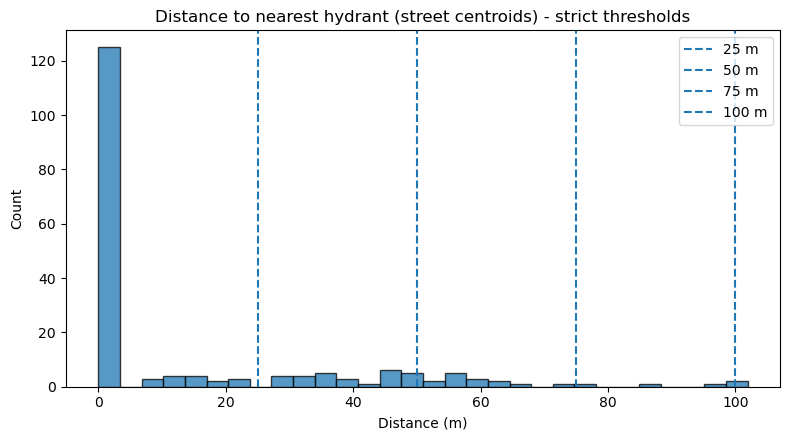


Generated strict threshold map: hydrant_accessibility_50m.html (green ≤ 50m, red > threshold)


In [40]:
# Quantile Overview
q = demand['dist_to_nearest_m'].quantile([0.5, 0.9, 0.95]).round(1)
print("\nCritical quantile (m):")
print(pd.DataFrame({'percentile':['p50','p90','p95'], 'distance_m':[q.loc[0.5], q.loc[0.9], q.loc[0.95]]}))

print("\nMaximum/minimum (m):")
print(pd.Series({
    'min': round(demand['dist_to_nearest_m'].min(), 1),
    'mean': round(demand['dist_to_nearest_m'].mean(), 1),
    'max': round(demand['dist_to_nearest_m'].max(), 1),
}))

# Use strict thresholds
strict_thresholds = [25, 50, 75, 100] 
coverage_summary_strict = []

total_weight = demand['population_density'].sum()

for thr in strict_thresholds:
    mask = demand['dist_to_nearest_m'] <= thr
    covered = mask.sum()
    covered_rate = covered / len(demand)
    covered_weight = demand.loc[mask, 'population_density'].sum()
    covered_rate_pop = covered_weight / total_weight if total_weight > 0 else np.nan
    coverage_summary_strict.append({
        'radius_m': thr,
        'covered_points': int(covered),
        'total_points': len(demand),
        'coverage_rate': covered_rate,
        'coverage_rate_pop_weighted': covered_rate_pop
    })

cov_strict_df = pd.DataFrame(coverage_summary_strict)
print("\nCoverage under strict thresholds：")
display(cov_strict_df.style.format({'coverage_rate':'{:.1%}', 'coverage_rate_pop_weighted':'{:.1%}'}))

# Measure whether the target is met by a "target threshold" (e.g. 50 m)
policy_thr = 50  
demand['covered_policy'] = demand['dist_to_nearest_m'] <= policy_thr
blind_policy = demand.loc[~demand['covered_policy']].copy()

print(f"\nNumber of non-compliant (>{policy_thr}m)：{len(blind_policy)} / {len(demand)} ({len(blind_policy)/len(demand):.1%})")

# List the top-N longest distance street segments
TOP_N = 10
if 'street_segment_lupvalue' in regression_df.columns:
    demand_with_name = demand.join(
        regression_df[['street_segment_lupvalue']],
        how='left'
    )
else:
    demand_with_name = demand.copy()
    demand_with_name['street_segment_lupvalue'] = '(unknown)'

top_far = (demand_with_name
           .sort_values('dist_to_nearest_m', ascending=False)
           .head(TOP_N)[['street_segment_lupvalue','centroid_lat','centroid_lon','dist_to_nearest_m']])
top_far['dist_to_nearest_m'] = top_far['dist_to_nearest_m'].round(1)
print(f"\nFarthest Top-{TOP_N} street segment：")
display(top_far)

# Histogram
plt.figure(figsize=(8,4.5))
plt.hist(demand['dist_to_nearest_m'], bins=30, alpha=0.75, edgecolor='k')
for t in strict_thresholds:
    plt.axvline(t, ls='--', lw=1.5, label=f'{t} m')
plt.title('Distance to nearest hydrant (street centroids) - strict thresholds')
plt.xlabel('Distance (m)')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# Update the map based on policy_thr to distinguish between those who meet the target and those who do not
map_center = [demand['centroid_lat'].mean(), demand['centroid_lon'].mean()]
m2 = folium.Map(location=map_center, zoom_start=15, tiles='OpenStreetMap')

# Draw equidistant circles for fire hydrant policy_thr
show_buffers = False
if show_buffers:
    for _, r in supply.iterrows():
        folium.Circle(
            location=[r['lat'], r['lon']],
            radius=policy_thr,
            fill=True, color='#89CFF0', fill_opacity=0.08, weight=1
        ).add_to(m2)

for _, r in demand.iterrows():
    color = 'green' if r['covered_policy'] else 'red'
    folium.CircleMarker(
        location=[r['centroid_lat'], r['centroid_lon']],
        radius=4,
        color=color, fill=True, fill_opacity=0.9,
        popup=(f"Street: {r.get('street_segment_lupvalue','(unknown)')}\n"
               f"Nearest: {r['dist_to_nearest_m']:.1f} m")
    ).add_to(m2)

map_file2 = f'hydrant_accessibility_{policy_thr}m.html'
m2.save(map_file2)
print(f"\nGenerated strict threshold map: {map_file2} (green ≤ {policy_thr}m, red > threshold)")
try:
    from IPython.display import IFrame
    display(IFrame(map_file2, width=900, height=600))
except:
    pass


### Conclusion

The distance from street centres to the nearest fire hydrant ranges from 0 to 101.9 metres, with an average of only 13.9 metres, indicating very high overall coverage. Quantile statistics show that 90% of street segments are within 50.6 metres, and 95% are within 59.5 metres, meaning that a fire hydrant is within a roughly one-minute walk of most street segments. Regarding service coverage, 25% of street segments are still not covered at the 25-metre threshold, but coverage reaches 89.4% at the 50-metre threshold, with only 10.6% (20 street segments) failing to meet the standard. Further relaxing the threshold to 100 metres, coverage approaches 100% (99.5%). Street segments that fail to meet the standard are primarily concentrated in areas such as Lorimer Street (101.9 metres), Todd Road, Walsh Street, Salmon Street, and Vegemite Way. These are often located in urban fringe areas or industrial areas, presenting potential fire safety vulnerabilities. The histogram results show that most street segments are within 0–10 metres of fire hydrants, while the map visually displays green coverage and red gaps.
The overall layout of hydrants is relatively reasonable, with most street segments accessible within 50–100 metres, demonstrating a high level of urban fire protection accessibility. However, a small number of marginal street segments (approximately 10%) still lack coverage. Additional fire hydrants in these areas should be prioritized to meet the strict 50-meter safety standard and further enhance overall fire protection capabilities.

## Suggestions 

1. Coexistence of Localized Overcrowding and Sparseness  
Cluster and spatial analysis show that some streets have excessively high fire hydrant densities, while a few areas (such as the Lorimer Street area) have hydrants that are too far apart (>100 metres). It is recommended that additional fire hydrants be installed in these sparsely populated areas to improve overall coverage balance.

2. Current coverage is high, but there are local blind spots.  
Accessibility analysis shows that approximately 10% of streets still fail to meet the 50m threshold, particularly on marginal roads. It is recommended that improvements be focused on these areas in conjunction with urban planning to avoid blind spots in fire emergency response.

3. Inadequate Matching Between Population Density and Coverage  
Regression and spatial regression results indicate that population density has limited explanatory power for the number of fire hydrants, and some densely populated neighbourhoods do not have more fire hydrants. It is recommended that future fire hydrant placement be considered in light of population distribution rather than relying solely on road length.

4. Updated Fire Hydrant Standards  
Currently, most streets have near-100% accessibility at both the 75m and 100m thresholds, indicating a reasonable overall layout. However, using the stricter 50m standard for evaluation reveals shortcomings. We recommend gradually tightening the planning standard to 50–75m to meet higher safety requirements.

5. Prioritize the expansion of key nodes  
Roads far from fire hydrants are often arterial or marginal, which can delay response in the event of a fire. We recommend prioritizing the installation of facilities at these key nodes.

6. Dynamic Monitoring and Updating  
As population density and urban development change, the layout of fire hydrants should also be dynamically adjusted. Consider establishing a regular spatial accessibility analysis mechanism to evaluate and optimize the layout every 3–5 years.

## Reference

Raškauskaitė, R. & Grigonis, V., 2019. An Approach for the Analysis of the Accessibility of Fire Hydrants in Urban Territories. ISPRS International Journal of Geo-Information, 8(12), p.587. 
MDPI

Yu, W., Huang, Y., Chen, Y. & Xia, Z., 2022. Accessibility analysis of urban fire stations within communities: a fine-scale perspective. Journal of Geographical Systems, 24(3), pp.611-640. 
SpringerLink

Boncinelli, L., Miricola, S. & Vicario, E., 2025. Quantifying walkable accessibility to urban services: An application to Florence, Italy. arXiv preprint arXiv:2504.12934. 
arXiv

Li, R., Wang, J. & Li, M., 2022. Fine-resolution evaluation of urban fire service accessibility under the impact of a 100-year pluvial flood. Progress in Geography, 41(1), pp.143-156. 
progressingeography.com

Mohebbi, M., Wolfe, R. & Jolley, D., 2011. A Poisson regression approach for modelling spatial autocorrelation between geographically referenced observations. BMC Medical Research Methodology, 11, Art. No. 133.